# [SOLUTION] Exercise 5: Understanding Binary Cross-Entropy Loss Variants

Binary classification seems simple: just predict class 1 or class 0. But choosing the right loss function variant matters more than you might think. Different variants expect different input formats (raw logits vs probabilities), and using the wrong one can cause errors or silent numerical instability. That's why PyTorch provides many different specialized loss variants.

> **Overview**: Explore how different Binary Cross-Entropy loss variants behave when your model outputs raw logits versus probabilities. Discover why numerical stability matters and the importance of choosing the right PyTorch loss functions.
> 
> **Scenario**: Your agricultural weather system predicts whether it will rain tomorrow (precipitation > 0) so farmers can schedule outdoor work and protect equipment. You've built a model that outputs a single raw value (logit) representing rain likelihood. Now you need to measure how well it's performing, but which loss function should you use?
> 
> **Goal**: Build intuition for matching loss functions to model output formats and understand why numerical stability matters in deep learning.
> 
> **Tools**: Python, PyTorch, Pandas, Matplotlib
> 
> **Estimated Time**: 20 minutes

## Step 1: Setup

Let's import our libraries and set up the environment.

In [1]:
# Import core libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Setup complete!")
print(f"PyTorch version: {torch.__version__}")

Setup complete!
PyTorch version: 2.5.1+cu121


## Step 2: Load and prepare the data

We'll use the [VerisimilitudeX/Weather](https://huggingface.co/datasets/VerisimilitudeX/Weather) dataset, which contains daily weather observations from 300+ US weather stations.

For this exercise, we'll:
1. Load the dataset
2. Create binary rain labels (1 = rain, 0 = no rain) based on precipitation measurements
3. Extract weather features for prediction
4. Sample a subset of 100 examples
5. Convert features and labels to tensors
6. Normalize the features for stability

**IMPORTANT: Feel free to skip to Step 3 if you want to focus on loss functions**. Just know you end up with two normalized weather features (temperature, wind speed) and binary rain labels for classification.

In [2]:
# 1. Load the dataset
dataset = load_dataset('VerisimilitudeX/Weather', split='train')
print(f"✓ Dataset loaded: {len(dataset)} weather observations\n")

# Convert to pandas
df = pd.DataFrame(dataset)

# 2. Create binary rain labels (1 if precipitation > 0, else 0)
df['rain'] = (df['Data.Precipitation'] > 0).astype(int)

# 3. Extract features: temperature, wind speed
df_clean = df[['Data.Temperature.Avg Temp', 'Data.Wind.Speed', 'rain']].dropna()

print(f"✓ Created {len(df_clean)} samples with rain labels")
print(f"  Rain days: {df_clean['rain'].sum()} ({df_clean['rain'].mean()*100:.1f}%)")
print(f"  No-rain days: {(1-df_clean['rain']).sum()} ({(1-df_clean['rain'].mean())*100:.1f}%)")

✓ Dataset loaded: 16743 weather observations

✓ Created 16743 samples with rain labels
  Rain days: 12419 (74.2%)
  No-rain days: 4324 (25.8%)


> **Binary classification setup**: We've converted a continuous precipitation measurement into a binary decision (rain/no-rain). This is a classic classification problem now : given temperature and wind speed, predict whether it will rain. 
> 
> The model will output a single number representing rain likelihood.

In [3]:
# 4. Sample a batch of data for our experiments
sample_size = 100
sample_df = df_clean.sample(n=sample_size, random_state=42)

# 5. Convert features and labels to tensors
X = sample_df[['Data.Temperature.Avg Temp', 'Data.Wind.Speed']].values
y = sample_df['rain'].values

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# 6. Normalize features (important for neural networks)
X_tensor = (X_tensor - X_tensor.mean(dim=0)) / X_tensor.std(dim=0)

print(f"✓ Prepared batch of {sample_size} samples")
print(f"  Features shape: {X_tensor.shape}")
print(f"  Labels shape: {y_tensor.shape}")

✓ Prepared batch of 100 samples
  Features shape: torch.Size([100, 2])
  Labels shape: torch.Size([100])


> **Why normalize for loss computation?** Loss functions compare predictions to targets numerically. If features have very different scales (e.g., temperature in degrees vs wind speed in mph), the model's raw outputs can vary wildly in magnitude, leading to unstable loss values during training. 
> 
> Normalization ensures all features contribute equally, keeping loss values in a reasonable range and making model training smoother.

## Step 3: Create a simple model

You'll use a simple neural network that takes weather features as input and outputs a single raw value (logit) representing rain likelihood. This model hasn't been trained yet, but it still produces outputs you can understand (and improve on) with loss functions.

> **Understanding the model architecture**:  You're given a simple 2-layer network with a critical detail: the final layer has **no activation function**. This means it outputs raw logits (unbounded real numbers like -2.5 or 3.8), not probabilities. When you call the model, it returns shape [100, 1], but [`squeeze()`](https://docs.pytorch.org/docs/master/generated/torch.squeeze.html) removes that extra dimension to get [100], matching your labels' shape. This squeeze step is a common PyTorch pattern for when a layer or operation returns an unnecessary singleton dimension that doesn’t match the shape you need.

**Key point**: The model outputs raw logits, which is the standard PyTorch pattern for binary classification. Why combine activation and loss computation into one step? You're about to find out.

In [4]:
# Create a simple model that outputs raw logits (no sigmoid activation)
class RainPredictor(nn.Module):
    def __init__(self, input_size=2):
        super(RainPredictor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 8),
            nn.ReLU(),
            nn.Linear(8, 1)  # Output layer: NO activation = raw logits
        )
    
    def forward(self, x):
        return self.network(x).squeeze()  # Remove extra dimension

# Create model and get predictions
model = RainPredictor()

# Get predictions (logits) from the untrained model
with torch.no_grad():
    logits = model(X_tensor)

print("✓ Model created and predictions generated\n")
print(f"Sample logits (first 10):")
print(logits[:10].numpy())
print(f"\nLogit range: [{logits.min():.2f}, {logits.max():.2f}]")

✓ Model created and predictions generated

Sample logits (first 10):
[-0.4451218  -0.5270579   0.00658706 -0.4521542   0.10493542 -0.01768389
 -0.00879979 -0.38016954 -0.5131235   0.05115302]

Logit range: [-1.22, 0.19]


> **Understanding logits**: The model outputs raw, unbounded numbers called "logits". These are NOT probabilities:
> - Logits can be any real number: negative, zero, or positive
> - Positive logits suggest "rain," negative logits suggest "no rain"
> - The magnitude indicates confidence
> 
> To convert logits to probabilities, you need to apply an activation function like the sigmoid. But should you do this manually before computing loss, or let the loss function handle it?

## Step 4: Experiment with binary cross-entropy loss variants

Now comes the core investigation: _Which loss function should you use for a model that outputs raw logits?_ You'll test different approaches and discover why PyTorch provides specialized loss variants.

You'll explore:
- **Step 4.1**: Choose and test a loss function for binary classification
- **Step 4.2**: Troubleshooting different outcomes
- **Step 4.3**: Compare loss approaches across batches
- **Step 4.4**: Test numerical stability with extreme values
- **Step 4.5**: Reflect on what you learned

Let's start experimenting!

### Step 4.1: Compute a binary classification loss

You have raw logits from your model and binary rain labels. Your first task is to compute a loss that measures how well the predictions match the labels.

In [5]:
# TODO: Create a loss function for binary classification and compute the loss
# HINT: PyTorch has several loss functions for classification in the nn module.
# What seems appropriate for binary classification (two classes: rain vs no-rain)?
# Reference: https://pytorch.org/docs/stable/nn.html#loss-functions

# Create your loss function by calling the right pytorch class
loss_fn = nn.BCELoss() # Add your code here

# Compute the loss with predicted logits and true y tensor labels
try:
    loss_value = loss_fn(logits, y_tensor) # Add your code here
    print(f"   Loss function {loss_fn} successfully called.")
    print(f"\n→ Continue to Step 4.2 to verify this is the right approach and see alternatives!")
    
except Exception as e:
    print(f"⚠︎  Error occurred: {e}")
    print(f"\n→ Continue to Step 4.2 for guided troubleshooting based on your error.")

⚠︎  Error occurred: all elements of input should be between 0 and 1

→ Continue to Step 4.2 for guided troubleshooting based on your error.


### Step 4.2: Troubleshooting your loss

Check what happened in Step 4.1 and follow the matching path below:

##### ✖ Path A: Got an error: "all elements of input should be between 0 and 1"

Your loss function expects probabilities (values in [0, 1]), but your model outputs raw logits (unbounded values). You need to convert logits to probabilities first.

_[Continue to [Path A: Add activation function](#path-a-add-activation-function)]_

##### ✖ Path B: Got a different error (TypeError, RuntimeError, shape mismatch, etc.)

This is likely an issue with variable names, types, or argument order rather than the loss function choice itself.

_[Continue to [Path B: Calling loss function on the right inputs](#path-b-calling-loss-function-on-the-right-inputs)]_

##### ✓ Path C: No error - loss computed successfully!

Great! Your code ran without errors. But the loss function could still run successfully even if you're using the wrong loss function for binary classification with logits.

**Run this check:**
```python
print(f"Loss function used: {loss_fn}")
print(f"Loss value: {loss_value.item():.4f}")
```

**Interpret your result:**
- **Loss between 0.3 - 2.0?** → Typical range for binary classification losses ✓
- **Getting a different loss range?** → You may not be using the right loss: Think of classification vs. regression, for example. Try again Step 4.1 with a different loss, or continue to the recommended approach!

> **Want to see PyTorch's recommended approach?** _Continue to [Path C: Discover PyTorch's recommended approach](#path-c-discover-pytorchs-recommended-approach)._


#### Path A: Add activation function

If you saw an error mentioning "target must be in [0, 1]" or similar, your loss function expects probabilities (values between 0 and 1) [e.g., `BCELoss`], but your model outputs raw logits (unbounded values).

**Want to fix this?** Convert logits to probabilities using an activation function that maps any real number to [0, 1].

In [6]:
# Path A: Fix the input mismatch
# TODO: Convert logits to probabilities, then compute BCELoss
# HINT: You need an activation function that maps any real number to the range [0, 1].
# Reference: https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

# Step 1: Convert logits to probabilities using the right activation function
probabilities = torch.sigmoid(logits) # Add your code here

# Step 2: Re-create your loss (expects probabilities as input)
probability_based_loss = nn.BCELoss() # Add your code here

# Step 3: Compute loss with the probabilities and true y tensor labels
try:
    loss_manual_fix = probability_based_loss(probabilities, y_tensor) # Add your code here

    print(f"✓ Fixed approach: {loss_manual_fix.item():.4f}")
    print(f"\nProbability range: [{probabilities.min():.4f}, {probabilities.max():.4f}]")
except Exception as e:
    print(f"⚠︎  Still getting an error: {e}")
    print(f"\nMake sure your probabilities are in the range [0, 1], and check [Path B] for possible input mismatches")

✓ Fixed approach: 0.7446

Probability range: [0.2272, 0.5476]


#### Path B: Calling loss function on the right inputs

If you saw a type error, runtime error, or similar, this is likely an issue with variable names, types, or argument order rather than the loss function choice itself.

**Want to fix this?** Check your inputs are correct, and fix your loss based on checks.

In [7]:
# First, let's check your inputs are correct
print("Debugging - checking inputs:")
print(f"Logits - Type: {type(logits)}, Shape: {logits.shape}")
print(f"Labels - Type: {type(y_tensor)}, Shape: {y_tensor.shape}")
print(f"Sample logits: {logits[:3]}")
print(f"Sample labels: {y_tensor[:3]}")

Debugging - checking inputs:
Logits - Type: <class 'torch.Tensor'>, Shape: torch.Size([100])
Labels - Type: <class 'torch.Tensor'>, Shape: torch.Size([100])
Sample logits: tensor([-0.4451, -0.5271,  0.0066])
Sample labels: tensor([0., 0., 0.])


In [8]:
# TODO: Fix your loss computation based on the checks above
# Make sure you're using:
# - logits (model predictions)
# - y_tensor (binary labels)
# - Correct order: loss_fn(predictions/logits, labels)

loss_fn = nn.BCELoss()  # Add your code here

try:
    fixed_loss = loss_fn(logits, y_tensor)  # Add your code here

    print(f"✓ Loss computed successfully: {loss_value.item():.4f}")
    print(f"\nIf this worked, continue to Path C to verify you're using the right loss.")
    
except Exception as e:
    print(f"⚠︎  Still getting an error: {e}")
    print(f"\nMake sure your inputs to loss_fn are correct and, if they are, check [Path A] for possible activation requirements")

⚠︎  Still getting an error: all elements of input should be between 0 and 1

Make sure your inputs to loss_fn are correct and, if they are, check [Path A] for possible activation requirements


#### Path C: Discover PyTorch's recommended approach

The recommended approach for binary classification in PyTorch is to use [`BCEWithLogitsLoss()`](https://docs.pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) which combines the activation function and loss computation into one numerically stable operation. It expects raw logits as input.

In [9]:
# TODO: Use BCEWithLogitsLoss on raw logits
# HINT: This loss function expects raw logits and handles the activation internally
# Reference: https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html

bce_with_logits_loss = nn.BCEWithLogitsLoss()  # Add your code here

try:
    # Compute the loss with predicted logits and true y tensor labels (no activation needed!)
    loss_with_logits = bce_with_logits_loss(logits, y_tensor)  # Add your code here

    print(f"✓ BCEWithLogitsLoss on raw logits: {loss_with_logits.item():.4f}")
except Exception as e:
    print(f"⚠︎  Error: {e}")
    print(f"Check that you are using the BCEWithLogitsLoss loss function and passing (logits, y_tensor).")

✓ BCEWithLogitsLoss on raw logits: 0.7446


**BCELoss vs BCEWithLogitLoss**: If you completed Path A, you'll notice the loss values are nearly identical (if not identical). Both approaches compute the same loss mathematically. So why does PyTorch provide BCEWithLogitsLoss? We'll explore the answer (numerical stability) in Step 4.4.

### Step 4.3: Compare loss approaches across batches

Let's systematically compare the two common approaches for binary classification (manual sigmoid + BCELoss vs BCEWithLogitsLoss) across multiple random batches to see if they behave consistently.

In [10]:
# Compute both losses across multiple random batches
num_batches = 10
losses_manual = []
losses_with_logits = []

# Create loss functions
bce_loss = nn.BCELoss()
bce_with_logits_loss = nn.BCEWithLogitsLoss()

for i in range(num_batches):
    # Get new predictions from model (simulating different batches)
    batch_indices = torch.randperm(len(X_tensor))[:50]
    X_batch = X_tensor[batch_indices]
    y_batch = y_tensor[batch_indices]
    
    with torch.no_grad():
        logits_batch = model(X_batch)
    
    # Approach 1: Manual sigmoid + BCELoss
    probs_batch = torch.sigmoid(logits_batch)
    loss_manual = bce_loss(probs_batch, y_batch)
    losses_manual.append(loss_manual.item())
    
    # Approach 2: BCEWithLogitsLoss
    loss_logits = bce_with_logits_loss(logits_batch, y_batch)
    losses_with_logits.append(loss_logits.item())

print(f"Manual sigmoid + BCELoss across {num_batches} batches:")
print(f"Mean loss: {np.mean(losses_manual):.4f} ± {np.std(losses_manual):.4f}")

print(f"\nBCEWithLogitsLoss across {num_batches} batches:")
print(f"Mean loss: {np.mean(losses_with_logits):.4f} ± {np.std(losses_with_logits):.4f}")

Manual sigmoid + BCELoss across 10 batches:
Mean loss: 0.7423 ± 0.0272

BCEWithLogitsLoss across 10 batches:
Mean loss: 0.7423 ± 0.0272



Both methods produce the exact same results on normal data.
But BCEWithLogitsLoss has a hidden advantage: numerical stability...


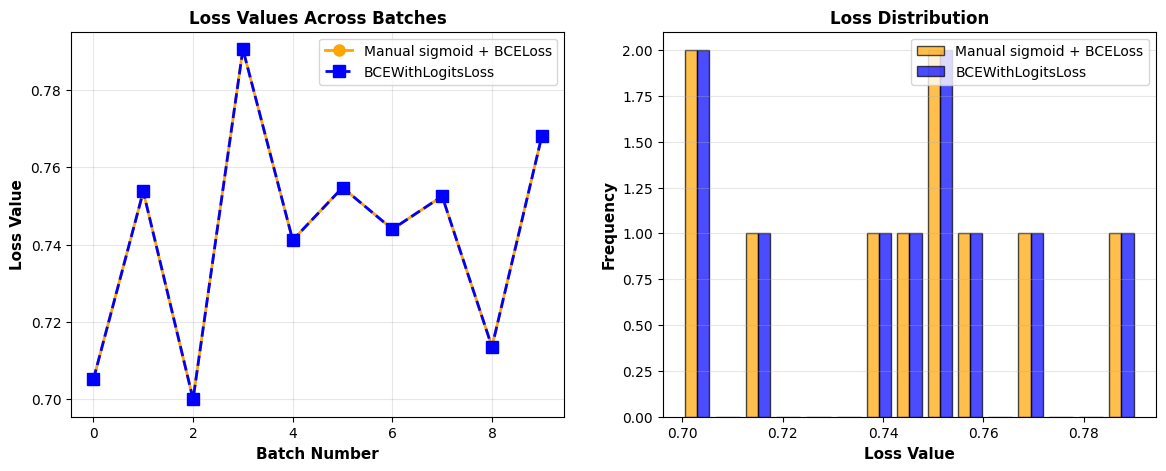

In [11]:
# Create side-by-side comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss values across batches
x = np.arange(num_batches)
axes[0].plot(x, losses_manual, 'o-', label='Manual sigmoid + BCELoss', 
            color='orange', linewidth=2, markersize=8)
axes[0].plot(x, losses_with_logits, 's--', label='BCEWithLogitsLoss', 
            color='blue', linewidth=2, markersize=8)
axes[0].set_xlabel('Batch Number', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Loss Value', fontsize=11, fontweight='bold')
axes[0].set_title('Loss Values Across Batches', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Side-by-side histograms
bin_edges = np.linspace(min(min(losses_manual), min(losses_with_logits)),
                        max(max(losses_manual), max(losses_with_logits)), 16)
axes[1].hist([losses_manual, losses_with_logits], bins=bin_edges,
            label=['Manual sigmoid + BCELoss', 'BCEWithLogitsLoss'],
            color=['orange', 'blue'], alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Loss Value', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1].set_title('Loss Distribution', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

print("\nBoth methods produce the exact same results on normal data.")
print("But BCEWithLogitsLoss has a hidden advantage: numerical stability...")

### Step 4.4 Testing numerical stability

The real difference between these approaches appears with extreme logit values. Let's test with very large positive and negative logits to see where manual sigmoid fails.

**Your task**: Test both approaches with extreme logits and observe what happens.

In [12]:
# Test with extreme logits that reveal the clamping behavior
extreme_logits = torch.tensor([-100.0, -50.0, -10.0, 0.0, 10.0, 50.0, 100.0])
extreme_labels = torch.tensor([1.0, 1.0, 1.0, 0.5, 0.0, 0.0, 0.0])

print("Testing numerical stability with extreme logits:\n")
print(f"{'Logit':<10} {'Sigmoid':<20} {'Manual+BCE':<20} {'BCEWithLogits':<20} {'Difference':<15}")
print("="*85)

for logit, label in zip(extreme_logits, extreme_labels):
    # Manual sigmoid + BCELoss
    prob = torch.sigmoid(logit)
    loss_manual = bce_loss(prob.unsqueeze(0), label.unsqueeze(0))
    
    # BCEWithLogitsLoss
    loss_logits = bce_with_logits_loss(logit.unsqueeze(0), label.unsqueeze(0))
    
    # Calculate difference
    diff = abs(loss_manual.item() - loss_logits.item())
    
    sigmoid_str = f"{prob.item():.15f}"
    manual_str = f"{loss_manual.item():.6f}"
    logits_str = f"{loss_logits.item():.6f}"
    diff_str = f"{diff:.6f}" if diff > 1e-6 else "~0"
    
    print(f"{logit.item():<10.1f} {sigmoid_str:<20} {manual_str:<20} {logits_str:<20} {diff_str:<15}")

print("\nKey observations:")
print("   • Logit = 10: Small difference (0.0005) - start of numerical issues")
print("   • Logit = 50: Manual gives 100, BCEWithLogits gives 50 (50-point error!)")
print("   • BCEWithLogitsLoss maintains accuracy across all extreme values")

Testing numerical stability with extreme logits:

Logit      Sigmoid              Manual+BCE           BCEWithLogits        Difference     
-100.0     0.000000000000000    100.000000           100.000000           ~0             
-50.0      0.000000000000000    50.000000            50.000000            ~0             
-10.0      0.000045397871872    10.000046            10.000046            ~0             
0.0        0.500000000000000    0.693147             0.693147             ~0             
10.0       0.999954581260681    9.999586             10.000046            0.000460       
50.0       1.000000000000000    100.000000           50.000000            50.000000      
100.0      1.000000000000000    100.000000           100.000000           ~0             

Key observations:
   • Logit = 10: Small difference (0.0005) - start of numerical issues
   • Logit = 50: Manual gives 100, BCEWithLogits gives 50 (50-point error!)
   • BCEWithLogitsLoss maintains accuracy across all extreme val

> **Why BCEWithLogitsLoss is more stable**: When logits are extreme (±50, ±100), sigmoid returns exactly 0.0 or 1.0, making log(0) = -∞. 
> 
> - `BCELoss` clamps this to -100 to prevent infinity, but creates approximated loss values (notice the 50-point error at logit=50). 
> - `BCEWithLogitsLoss` uses the log-sum-exp trick—computing `log(sigmoid(x)) = -log(1 + e^(-x))`—, which never evaluates log(0) and gives mathematically correct values. 
> 
> This matters because, during training, confident models can produce extreme logits and this numerical accuracy matters for reliable convergence.
>
> <details> <summary><i>But why do numerical differences not show at logit=100, even though the logit is even more extreme?</i></summary> 
> 
> Actually, they do! But both methods hit their limits. At such extreme values, even the log-sum-exp trick can't avoid floating-point overflow (e^100 ≈ infinity), so both approaches converge to the same approximation. The key insight: BCEWithLogitsLoss stays accurate **longer** (through logit=50), degrading only at values rarely seen in practice (100+).
> </details>

### Step 4.5: Collect your thoughts

Now that you've experimented with different loss approaches, reflect on what you've learned by answering these questions.

### TODO: Analysis Question 1

**If you encountered an error in Step 4.1, what caused it? What range of values does BCELoss expect as input, and why did raw logits cause a problem?**

_Write your answer below:_

BCELoss expects inputs to be probabilities in the range [0, 1] because its formula involves computing log(ŷ) and log(1-ŷ). When raw logits (which can be any real number, including negative values or values > 1) are passed to BCELoss, the logarithm operations become undefined or produce invalid results. For example, log of a negative number is undefined, and log(1-ŷ) fails when ŷ > 1.

### TODO: Analysis Question 2

**Manual sigmoid + BCELoss and BCEWithLogitsLoss produced similar results in Step 4.3. So why does PyTorch recommend BCEWithLogitsLoss? What advantage did you observe in Step 4.4?**

_Write your answer below:_

BCEWithLogitsLoss is numerically more stable than manually applying sigmoid followed by BCELoss. When logits are very large or very small (e.g., ±50), the manual approach can suffer from numerical overflow/underflow: sigmoid of extreme values approaches 0 or 1 exactly, and taking log of these values produces infinity or undefined results. BCEWithLogitsLoss uses the log-sum-exp trick to compute the combined operation in a single, numerically stable step that avoids these issues.

### TODO: Analysis Question 3

**When would you use CrossEntropyLoss instead of BCEWithLogitsLoss? What's the fundamental difference between binary and multi-class classification?**

_Write your answer below:_

Use CrossEntropyLoss for multi-class classification where each sample belongs to exactly one of multiple classes (e.g., predicting rain, snow, or clear weather). BCEWithLogitsLoss is for binary classification (two mutually exclusive outcomes). The fundamental difference is in the output layer: binary classification has 1 output neuron (positive class probability), while multi-class has C output neurons (one per class) that are processed through softmax to ensure probabilities sum to 1.

## Conclusion

Congratulations! You've discovered firsthand why choosing the right loss function variant matters for deep learning.

**What you've accomplished:**

- [x] **Experimented with loss function selection** - Chose and tested a loss function for binary classification
- [x] **Experienced potential mismatches** - Discovered what happens when loss expects probabilities but receives logits
- [x] **Learned multiple valid approaches** - Applied sigmoid manually or used BCEWithLogitsLoss
- [x] **Tested numerical stability** - Observed how extreme logits break manual sigmoid but not combined losses
- [x] **Built loss function intuition** - Understand why PyTorch provides specialized variants

**Critical insights:**

- **Loss functions must match model output format** - Raw logits need BCEWithLogitsLoss, probabilities need BCELoss
- **Numerical stability matters in production** - Combined sigmoid+loss implementations prevent overflow/underflow
- **Trust library implementations** - They handle edge cases and optimizations you might miss
- **Output layer design affects loss choice** - No activation (logits) vs sigmoid activation determines which loss to use

Loss functions are PyTorch objects that compare predictions to targets and output one scalar number: the smaller it is, the better your model's predictions. But choosing the right loss variant is just as important as choosing the right loss family. Always match your loss function to both your problem type (regression vs classification) and your model's output format (logits vs probabilities).

> **Next steps to explore**: Experiment with multi-class classification with CrossEntropyLoss, test the model’s behavior under class imbalance using weighted losses, and visualize the loss surface to better understand how training adjusts model parameters.